# Platform Positioning

In [86]:
from __future__ import print_function

In [87]:
import random as random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.metrics import euclidean_distances

###  Generate Well Concept Data

In [88]:
from dummydatacreator import  GenerateWellConcept # This is not supported in Azure notebooks

In [89]:
num_of_concepts = 30

region_x_min = -60.62
region_x_max = -59.98
region_y_min = 9.87
region_y_max = 10.45
WellConcepts = [GenerateWellConcept(region_x_min, region_x_max, region_y_min, region_y_max) for i in range(num_of_concepts)]

In [90]:
WC_name, WC_points, WC_resource = list(zip(*WellConcepts))

In [91]:
print(WellConcepts[0])

['W-21', [-60.593583825719236, 10.382362257596597], 61.4249765258931]


### Well Concept / Platform Intersection

In [7]:
def ArePointsCloseTogether(pointA, pointB, distance):
    return (euclidean_distances([pointA], [pointB]) <= distance)[0][0]

print(ArePointsCloseTogether([10,2], [0,0], 10))

False


In [8]:
def AreWCsCloseToPlatforom(WellConceptsXY, PlatformXY, distance):    
    return [ArePointsCloseTogether(wcXY, PlatformXY, distance) for wcXY in WellConceptsXY]

In [72]:
def CalculateRankOfWCs(WC, plat, radii):
    '''Well Concepts are ranked according to binned distance from platform
    '''
    radii = np.sort(radii)
    num_radii = len(radii)

    #calculate distances of all well concepts from platform 
    distances = [distance.distance(wc_i, plat) for wc_i in WC]
    distances = np.reshape(distances,[-1])

    
    #Reverse ranking - where 0 is closest to platform
    revranks = np.digitize(distances, radii, right = False) #i.e. includes left bound = 0

    # Ranking - where 0 is furthest from platform
    ranking = [num_radii - revrank for revrank in revranks]
    
    return ranking

In [10]:
def RankToColors(WC_rank):
    dct_colors = {0: None,
              1:"#FF8000",
              2:"#00CC00"}
    return dct_colors[WC_rank]

In [ ]:
#def PlatformRadiiHeatmap(platforms, radii):
np.    
    


# Plotting - Geography

In [38]:
from geopy import distance

In [35]:
euclidean_distances([[a.x, a.y] for a in WC_points], [[-60.2,10]])

array([[0.4649178 ],
       [0.07260335],
       [0.30758298],
       [0.14976011],
       [0.29174563],
       [0.43225644],
       [0.41459432],
       [0.14038416],
       [0.15929167],
       [0.28101669],
       [0.3051274 ],
       [0.44041675],
       [0.47211444],
       [0.22613242],
       [0.40192825],
       [0.29057683],
       [0.33251801],
       [0.26780035],
       [0.36922236],
       [0.07198759],
       [0.171867  ],
       [0.37516365],
       [0.09692714],
       [0.27373546],
       [0.24050814],
       [0.33687508],
       [0.1501193 ],
       [0.30492648],
       [0.48978222],
       [0.13170693]])

In [45]:
for i in range(len(WC_points)):
    print(distance.distance([WC_points[i].x, WC_points[i].y], [-60.2,10]))

33.01568488742097 km
5.421583196399606 km
33.285834848323404 km
8.68943652792124 km
32.501335194627636 km
27.5218577729519 km
37.61026261491322 km
13.099826934475585 km
10.808074591883384 km
20.420284357846775 km
30.307857877472838 km
25.556553683060308 km
42.26379071690247 km
16.52254234364927 km
29.363071481752577 km
20.18194233806722 km
36.738275848489494 km
15.63322881157877 km
24.65002225889747 km
4.016071826612781 km
13.898385968952933 km
41.7196364919122 km
10.209362170508653 km
29.728426306414605 km
26.10464542228934 km
21.201729269508593 km
13.277405487074263 km
32.69599228295135 km
33.440046936356936 km
14.090747340553186 km


In [12]:
import geopandas as gpd
from shapely.geometry import Point, LineString

In [13]:
WC_points = [Point(p[0], p[1]) for p in WC_points]
WC_points = gpd.GeoSeries(WC_points)

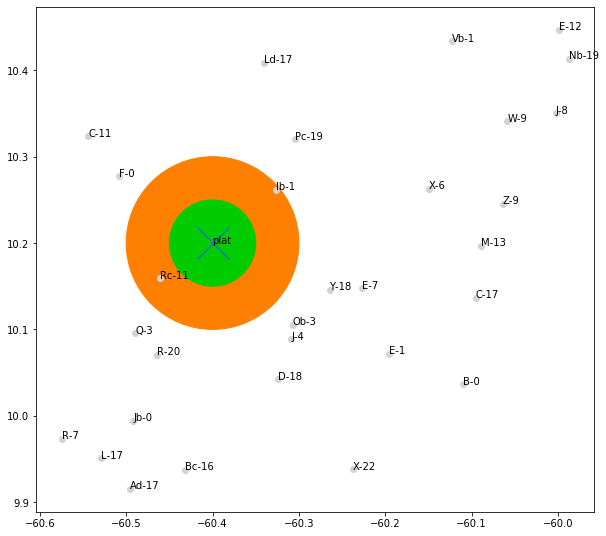

In [76]:
def plot_WC_Platform(WC_Point : Point,WC_name, WC_res: np.array, plat_x, plat_y, plat_name, innerradius, outerradius, figsize):

    '''
    Plots Well Concepts and Platforms in Euclidean geometry
    '''
    
    
    #Unpack XY coordinates
#    WC_x = [XY[0]for XY in WC_points] 
#    WC_y = [XY[1]for XY in WC_points]

    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(plat_x, plat_y, marker = 'x', s=1000, zorder=2 )


    
    platform_radius = plt.Circle((plat_x, plat_y), radius = outerradius,fill=True,color='#FF8000', zorder=0 )
    ax.add_artist(platform_radius)
    
    platform_radius = plt.Circle((plat_x, plat_y), radius = innerradius,fill=True,color='#00CC00', zorder=1 )
    ax.add_artist(platform_radius)
    
    #Well concept labels
    for i, x in enumerate(WC_name):
        ax.annotate(WC_name[i], ([WC_Point[i].x, WC_Point[i].y]), zorder=2)

    ax.annotate(plat_name, (plat_x, plat_y))
    WC_Point.plot(ax=ax, color="#D3D3D3", label=WC_res)

plot_WC_Platform(WC_points, WC_name, WC_resource, -60.4,10.2,"plat",0.05,0.1,(10,10))

In [82]:
def CreamMe(plat_x, plat_y, innerradius, outerradius, figsize):

    #Subset the WCs to only those which are on the creaming curve
    WC_rank = CalculateRankOfWCs([(a.x, a.y) for a in WC_points],(plat_x,plat_y),[0, innerradius, outerradius])

    #Construct dataframe of all well concepts
    df_WC = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource, "Rank":WC_rank})
    
    #Reduce to df of well concepts on Creaming Curve (i.e. within the radii)
    df_WC_cc = df_WC[df_WC['Rank'] != 0].copy()
    
    
    df_WC_cc.loc[:,'Color'] = df_WC_cc['Rank'].map(lambda x: RankToColors(x))
    
    df_WC_cc.sort_values(by="Resource", inplace=True, ascending=False)
    
    
    

    fig, ax = plt.subplots(figsize=figsize)    

    ax.bar(df_WC_cc['Well Concept'], df_WC_cc['Resource'], color=df_WC_cc['Color'])

    ax.set_xlabel("Well Concept Name")
    ax.set_ylabel("Resource")
    plt.show()






In [83]:
userInputs = [widgets.BoundedFloatText(
    value=round(region_x_min +(random.random()*(region_x_max-region_x_min)), 2 ),
    min=region_x_min,
    max=region_x_max,
    step=0.01,
    description='X:',
    disabled=False
),
widgets.BoundedFloatText(
    value=round(region_y_min +(random.random()*(region_y_max-region_y_min)), 2 ),
    min=region_y_min,
    max=region_y_max,
    step=0.01,
    description='Y:',
    disabled=False
),
  widgets.BoundedFloatText(
    value=0.05,
    min=0.01,
    max=100,
    step=0.01,
    description='Radius:',
    disabled=False
)]



In [84]:
#%matplotlib inline 
from IPython.display import display

output = widgets.Output(layout={'border': '1px solid black'})


def on_button_clicked(event):
    output.clear_output()

    with output:
        plat_x = userInputs[0].value
        plat_y = userInputs[1].value
        radius = userInputs[2].value
        plot_WC_Platform(WC_points, WC_name, WC_resource,plat_x,plat_y,"platform", radius,radius*1.3, (12,10))
        CreamMe(plat_x, plat_y, radius,radius*1.3, (5,5))
    
        print("Button clicked.")        
        
button = widgets.Button(
    description='click me',
    layout={'width': '300px'},
    button_style='success', 
    tooltip='Run',
    icon='refresh'
)

display(widgets.Box(userInputs), button)


button.on_click(on_button_clicked)


Box(children=(BoundedFloatText(value=-60.5, description='X:', max=-59.98, min=-60.62, step=0.01), BoundedFloat…

Button(button_style='success', description='click me', icon='refresh', layout=Layout(width='300px'), style=But…

In [85]:
output

Output(layout=Layout(border='1px solid black'))